# scNT-seq human hematopoiesis

In this tutorial, we will show how to estimate dynamics from new/total expressions (labeling) with Model2 from dynamo Cell paper and how our processed hematopoiesis dataset is generated. The corresponding results have been stored in ``dyn.sample_data.hematopoiesis``. We can directly access the processed hematopoiesis dataset based on needs.

In dynamo Cell paper Model2, we take into account labeling (with a labeling correction coefficient) but not splicing. The total RNA has a synthesis rate constant and a degradation rate constant. The labeled RNA has a reduced synthesis rate constant but the same degradation rate constant. For more theoretical parts and ODE equations, please refer to `dynamo` Cell paper.

In [1]:
%%capture

import dynamo as dyn
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

Read raw hematopoiesis data via ``dyn.sample_data.hematopoiesis_raw``. `new` and `total` layer will be used for dynamics estimation.

In [2]:
adata_hsc_raw = dyn.sample_data.hematopoiesis_raw()
adata_hsc_raw


AnnData object with n_obs × n_vars = 1947 × 26193
    obs: 'batch', 'cell_type', 'time'
    var: 'gene_name_mapping'
    uns: 'genes_to_use'
    obsm: 'X_umap'
    layers: 'new', 'spliced', 'total', 'unspliced'

The following code cells preprocess `adata`. We use a predefined gene list based on literature review and metrics such as highly variable genes. The gene list is stored in `adata_hsc_raw.uns["genes_to_use"]` of the hematopoiesis raw dataset we provide

In [3]:
selected_genes_to_use = adata_hsc_raw.uns["genes_to_use"]

In [4]:
dyn.pp.recipe_monocle(
    adata_hsc_raw,
    tkey="time",
    experiment_type="one-shot",
    genes_to_use=selected_genes_to_use,
    n_top_genes=len(selected_genes_to_use),
    # feature_selection_layer="new",
    maintain_n_top_genes=True,
)

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
[ Future queries will be cached in "/Users/random/dynamo_readthedocs/docs/source/notebooks/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-12000...done. [ from cache ]
querying 12001-13000...done. [ from cache ]
querying 13001-14000...done. [ from cache ]
querying 14001-15000...done. [ from cache ]
querying 15001-16000...don

In [5]:
adata_hsc_raw.var.use_for_pca.sum()

1766

In [6]:
dyn.tl.reduceDimension(adata_hsc_raw)

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.1038s]


## Apply model2 and one-shot modeling

In [7]:
dyn.tl.moments(adata_hsc_raw, group="time")

|-----> calculating first/second moments...


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [13.3928s]


Because we have unsplicing/splicing expressions in adata, our preprocess module recognizes it and assumes `adata` has splicing and labeling. We need to set `has_splicing` to be false in order to use Model2, which estimates dynamics without unsplicing/splicing and only considers labeling data (new/total).

In [8]:
adata_hsc_raw.uns["pp"]["has_splicing"] = False
dyn.tl.dynamics(adata_hsc_raw, group="time", one_shot_method="sci_fate", model="deterministic");


|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [3.3029s]


estimating alpha: 100%|██████████| 1766/1766 [00:00<00:00, 62856.01it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [2.2067s]


estimating alpha: 100%|██████████| 1766/1766 [00:00<00:00, 69459.31it/s]


In [9]:
dyn.tl.cell_velocities(
    adata_hsc_raw,
    enforce=True,
    method="cosine",
);

## One-shot labeling modeling

The one-shot labeling model from dynamo was used to estimate absolute total RNA velocities on the labeling data (new and total RNA). Because we quantified both the labeling and splicing information, we used the second formula   that involves both splicing and labeling data to define total RNA velocity. The high-dimensional velocity vectors were projected to two- dimensional UMAP space and visualized with the streamline plot, using dynamo with default parameters (Figure 3B). Similarly, the total RNA velocity plot in Figure 3D and total RNA phase diagram in Figure 3E for example gene PF4 were generated using dynamo with default settings.


In [10]:
adata_hsc_raw.obs.time.unique()


array([3, 5])

We have two time points in hsc dataset. Here we split the dataset based on time points and prepare data for calculation next.

In [11]:
pca_genes = adata_hsc_raw.var.use_for_pca
new_expr = adata_hsc_raw[:, pca_genes].layers["M_n"]
gamma = adata_hsc_raw[:, pca_genes].var.gamma
time_3_gamma = adata_hsc_raw[:, pca_genes].var.time_3_gamma.astype(float)
time_5_gamma = adata_hsc_raw[:, pca_genes].var.time_5_gamma.astype(float)

t = adata_hsc_raw.obs.time.astype(float)
M_s = adata_hsc_raw.layers["M_s"][:, pca_genes]

time_3_cells = adata_hsc_raw.obs.time == 3
time_5_cells = adata_hsc_raw.obs.time == 5

Next, we will calculate `velocity_alpha_minus_gamma_s` according to $$\alpha = new / (1 - e^{-rt}) \cdot r$$

In [12]:
def alpha_minus_gamma_s(new, gamma, t, M_s):
    # equation: alpha = new / (1 - e^{-rt}) * r
    alpha = new.A.T / (1 - np.exp(-gamma.values[:, None] * t.values[None, :])) * gamma.values[:, None]
    
    gamma_s = gamma.values[:, None] * M_s.A.T
    alpha_minus_gamma_s = alpha - gamma_s
    return alpha_minus_gamma_s

time_3_velocity_n = alpha_minus_gamma_s(new_expr[time_3_cells, :], time_3_gamma, t[time_3_cells], M_s[time_3_cells, :])
time_5_velocity_n = alpha_minus_gamma_s(new_expr[time_5_cells, :], time_5_gamma, t[time_5_cells], M_s[time_5_cells, :])

velocity_n = adata_hsc_raw.layers["velocity_N"].copy()

valid_velocity_n = velocity_n[:, pca_genes].copy()
valid_velocity_n[time_3_cells, :] = time_3_velocity_n.T
valid_velocity_n[time_5_cells, :] = time_5_velocity_n.T
velocity_n[:, pca_genes] = valid_velocity_n.copy()

adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"] = velocity_n.copy()

The results are stored in `adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"]`, which can be further projected to low dimension space for visualization.

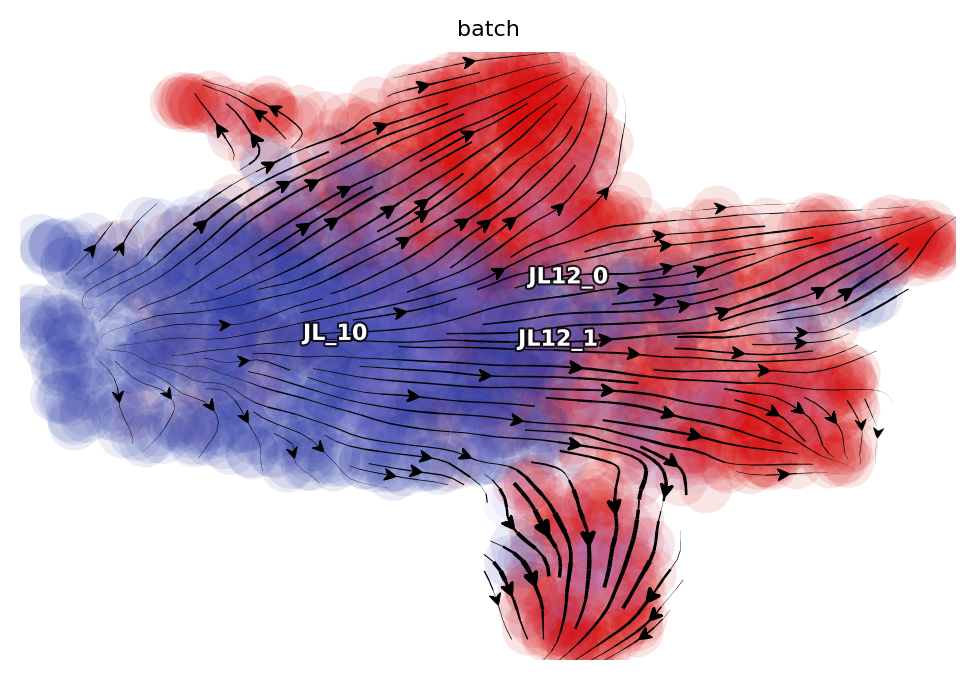

In [13]:
dyn.tl.cell_velocities(
    adata_hsc_raw,
    enforce=True,
    X=adata_hsc_raw.layers["M_t"],
    V=adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"],
    method="cosine",
);
dyn.pl.streamline_plot(
    adata_hsc_raw,
    color=["batch"],
    ncols=4,
    basis="umap",
)